# Data Challenge : Hand Gesture Recognition

#### Imad AOUALI - Anas ESSOUNAINI - Ali MOURTADA - Abdellah RAHMANI

In [0]:
import numpy as np
from scipy import misc
import os
import matplotlib.pyplot as plt
import csv
import pandas as pd
from pandas import read_csv

from keras.utils.vis_utils import plot_model
from keras.layers import Dense, Flatten, Dropout, ZeroPadding3D
from keras.layers.recurrent import LSTM, GRU
from keras.models import Sequential, load_model
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import TimeDistributed
from keras.layers.convolutional import (Conv1D, Conv2D, MaxPooling3D, Conv3D, MaxPooling2D,MaxPooling1D)
from collections import deque
import sys
from keras.layers import Convolution2D, Activation
from keras.callbacks import Callback
from sklearn.model_selection import train_test_split
from keras.models import model_from_json
from keras.utils import to_categorical

from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import optimizers
from keras.layers.normalization import BatchNormalization

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Important Functions :

In [0]:
# Function to load a csv skeleton file sequence
# dim_joint = 2 if joints coordinates expressed in the depth image
# dim_joint = 3 if joints coordinates expressed in 3D world spaces.
def read_csv_skeleton(file, dim_joints):
	n = []
	n_samples = 0
	n_frames = 0
	with open(file, 'r') as f:
		data = csv.reader(f, delimiter=' ')
		for d in data:
			n_samples += 1
			n_frames=0
			for j in d[0].split(','):
				n.append(float(j))
				n_frames += 1
    # convert data in numpy array
	n = np.asarray(n)
	n = np.reshape(n, (n_samples, n_frames//(22*dim_joints), 22, dim_joints))
	return n

In [0]:
# Function to load a csv skeleton file sequence
# It returns idx, sequence label and sizesequence (with non zero padding frames)
def read_csv_infos(file):
	idx = []
	labels = []
	sizesequences = []

	with open(file, 'r') as f:
		data = csv.reader(f, delimiter=' ')
		for d in data:
			j = d[0].split(',')
			idx.append(int(j[0]))
			labels.append(int(j[1]))
			sizesequences.append(int(j[2]))

	return idx, labels, sizesequences

In [0]:
def padd(data, n_dim):
  padd_data = np.zeros((840, 171, 22, n_dim))
  padd_data[:,:162,:,:] = data
  return padd_data

In [0]:
class TerminateOnBaseline(Callback):
    """Callback that terminates training when either acc or val_acc reaches a specified baseline
    """
    def __init__(self, monitor='acc', baseline=0.9):
        super(TerminateOnBaseline, self).__init__()
        self.monitor = monitor
        self.baseline = baseline

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        acc = logs.get(self.monitor)
        if acc is not None:
            if acc >= self.baseline:
                print('Epoch %d: Reached baseline, terminating training' % (epoch))
                self.model.stop_training = True

In [0]:
def vote_majoritaire(array):
  count = 0
  elem = array[0]
  for x in array:
    c = array.count(x)
    if c > count:
      elem = x
      count = c
  return elem 

# Data Processing :

### Training Data :

In [0]:
skeletons_image = read_csv_skeleton('/content/drive/My Drive/DataChallenge/skeletons_image_train.csv', 2)
skeletons_world = read_csv_skeleton('/content/drive/My Drive/DataChallenge/skeletons_world_train.csv', 3)
idx, labels, sequences = read_csv_infos('/content/drive/My Drive/DataChallenge/infos_train.csv')

In [0]:
X_train_world = skeletons_world
X_train_image = skeletons_image

In [0]:
labels = np.array(labels)

### Test Data :

In [0]:
skeletons_test_image = read_csv_skeleton('/content/drive/My Drive/DataChallenge/skeletons_image_test.csv', 2)
skeletons_test_world = read_csv_skeleton('/content/drive/My Drive/DataChallenge/skeletons_world_test.csv', 3)
sequence_test = pd.read_csv('/content/drive/My Drive/DataChallenge/infos_test.csv', names=['colA', 'colB'], header=None).iloc[:,1].values

In [0]:
X_test_world = padd(skeletons_test_world, 3)
X_test_image = padd(skeletons_test_image, 2)

### Sppliting the Data :

In [0]:
train_data_world, validation_data_world, y_train_world, y_test_world = train_test_split(X_train_world,labels, test_size=0.1, random_state = 0)
train_data_image, validation_data_image, y_train_image, y_test_image = train_test_split(X_train_image,labels, test_size=0.1,random_state = 0)
train_labels_CNN, validation_labels_CNN = to_categorical(y_train_image-1), to_categorical(y_test_image-1)
train_labels_GRU, validation_labels_GRU = to_categorical(y_train_world-1), to_categorical(y_test_world-1)

In [0]:
y_train_image == y_train_world

array([False, False, False, ..., False, False,  True])

# Deep Learning Models :

In [0]:
# Paramètres :

nb_filters1 = 32
nb_filters2 = 64
nb_filters3 = 128
nb_filters4 = 256
conv1_size = 5
conv2_size = 4
conv3_size = 3
conv4_size = 2
pool_size = 2
nb_classes = 28

timesteps = 171
dims = 66

### Convolutional Neural Network :

Dans cette partie, on a implémenté un réseau de neurones convolutionnel, formé de 4 couches de convolution.

On a commencé par une architecture non profonde mais, le modèle sur apprend très rapidement. Pour cela, on a décidé d'ajouter des couches de convolution et d'autres fully connected en utilisant l'option du Dropout. Chose qui nous a permis de regulariser le modèle et le rendre insensible à la variation des données.

In [0]:
def Model_CNN(nb_filters1, nb_filters2, nb_filters3, nb_filters4, conv1_size, conv2_size, conv3_size, conv4_size, pool_size, nb_classes):
  """
  Fonction qui génére un réseau de neurones convolutionnel.
  -----------------------------------------------
  Input:
    nb_filters1 : Int, le nombre de filtre de la première couche de convolution
    nb_filters2 : Int, le nombre de filtre de la deuxième couche de convolution
    nb_filters3 : Int, le nombre de filtre de la troisième couche de convolution
    nb_filters4 : Int, le nombre de filtre de la quatrième  couche de convolution
    conv1_size : Int, la taille du filtre de la première couche de convolution
    conv2_size : Int, la taille du filtre de la deuxième couche de convolution
    conv3_size : Int, la taille du filtre de la troisième couche de convolution
    conv4_size : Int, la taille du filtre de la quatrième couche de convolution
    pool_size : Int, la taille du noyau de kernel pour le pooling
    nb_classes : Int, nombre de classe
  -------------------------------------------------
  Output : 
    model : réseau de neurones convolutionnel formé de 4 couches de convolution et 3 couches fully connected.

  """
  # ------- ARCHITECTURE --------
  #Les couches de convolution
  model = Sequential()
  model.add(Convolution2D(nb_filters1, conv1_size, conv1_size, border_mode ="same", input_shape=(171, 22, 2)))
  model.add(Activation("elu"))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))
  model.add(Dropout(0.2))

  model.add(Convolution2D(nb_filters2, conv2_size, conv2_size, border_mode ="same"))
  model.add(Activation("elu"))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(pool_size, pool_size), dim_ordering='th'))
  model.add(Dropout(0.2))

  model.add(Convolution2D(nb_filters3, conv3_size, conv3_size, border_mode ="same"))
  model.add(Activation("elu"))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(pool_size, pool_size), dim_ordering='th'))
  model.add(Dropout(0.2))

  model.add(Convolution2D(nb_filters4, conv4_size, conv4_size, border_mode ="same"))
  model.add(Activation("elu"))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(pool_size, pool_size), dim_ordering='th'))
  model.add(Dropout(0.2))

  #Les couches Fully connected

  model.add(Flatten())
  model.add(Dense(125))
  model.add(Activation("elu"))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))

  model.add(Dense(125))
  model.add(Activation("elu"))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))

  model.add(Dense(64))
  model.add(Activation("elu"))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))

  #classification 
  model.add(Dense(nb_classes, activation='softmax'))

  # ------- Partie d'entrainement --------
  model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=0.00001), metrics=['categorical_accuracy'])
  
  return model

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), input_shape=(171, 22, ..., padding="same")`
  This is separate from the ipykernel package so we can avoid doing imports until








Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (4, 4), padding="same")`
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), data_format="channels_first")`
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="same")`
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), data_format="channels_first")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (2, 2), padding="same")`
/usr/local/lib/python3.6/dist-packag

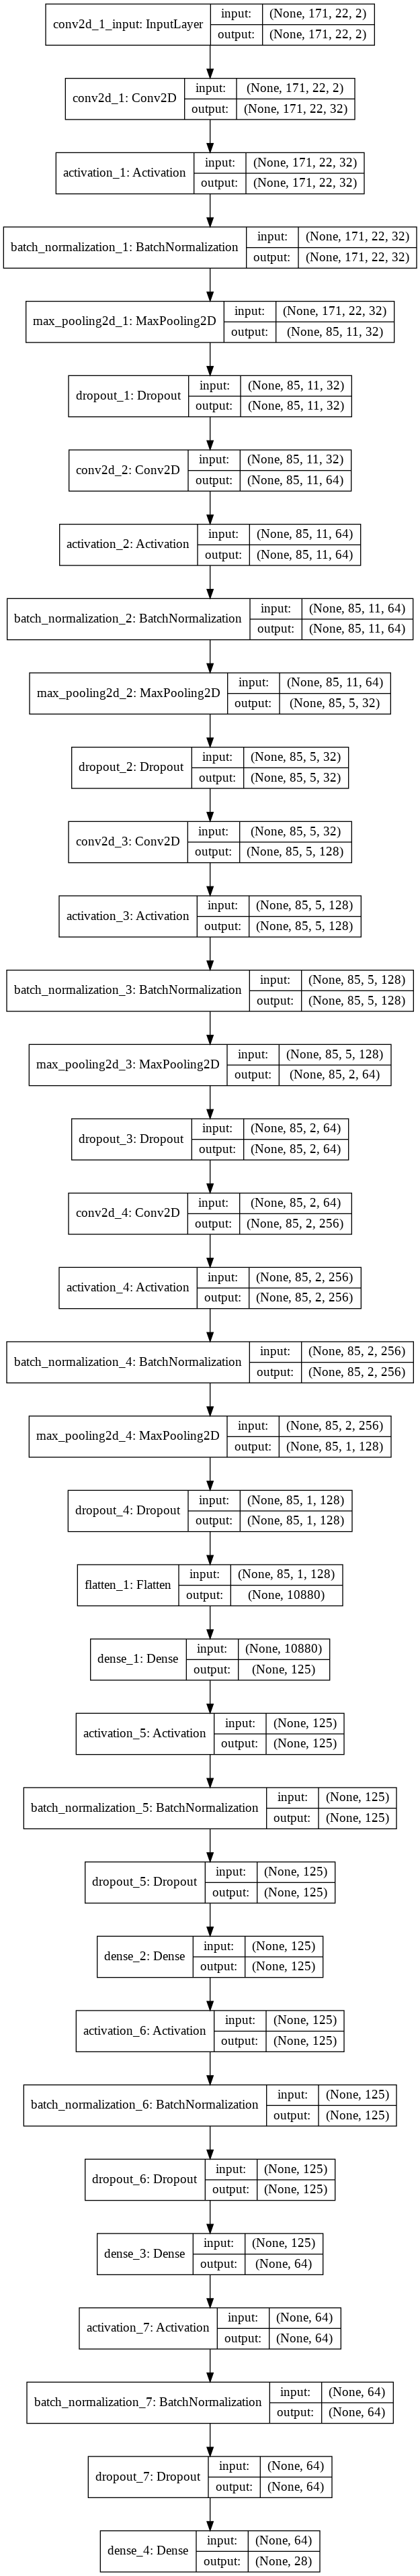

In [0]:
model_cnn = Model_CNN(nb_filters1, nb_filters2, nb_filters3, nb_filters4, conv1_size, conv2_size, conv3_size, conv4_size, pool_size, nb_classes)
plot_model(model_cnn, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### Gated Recurrent Unit :

In [0]:
def Model_GRU():
  #Model configration
  model = Sequential()

  model.add(Conv1D(input_shape=(timesteps,dims), filters=64, kernel_size=1, padding='valid', activation='tanh', strides=1))
  model.add(Dropout(0.12))
  model.add(BatchNormalization())
  model.add(MaxPooling1D(pool_size=2)) # strides=None means strides=pool_size

  model.add(Conv1D(filters=64, kernel_size=1, padding='valid', activation='tanh', strides=1))
  model.add(Dropout(0.27))
  model.add(BatchNormalization())
  model.add(MaxPooling1D(pool_size=2))


  model.add(Conv1D(filters=32, kernel_size=1, padding='valid', activation='tanh', strides=1))
  model.add(Dropout(0.27))
  model.add(BatchNormalization())
  model.add(MaxPooling1D(pool_size=2))
  model.add(GRU(128, return_sequences=True, activation='tanh', recurrent_activation='hard_sigmoid', recurrent_dropout=0.5))
  model.add(Dropout(0.3))
  model.add(BatchNormalization())


  model.add(GRU(64, return_sequences=False, activation='tanh', recurrent_activation='hard_sigmoid', recurrent_dropout=0.5))
  model.add(Dropout(0.25))
  model.add(BatchNormalization())
  model.add(Dense(28, activation='softmax'))

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model

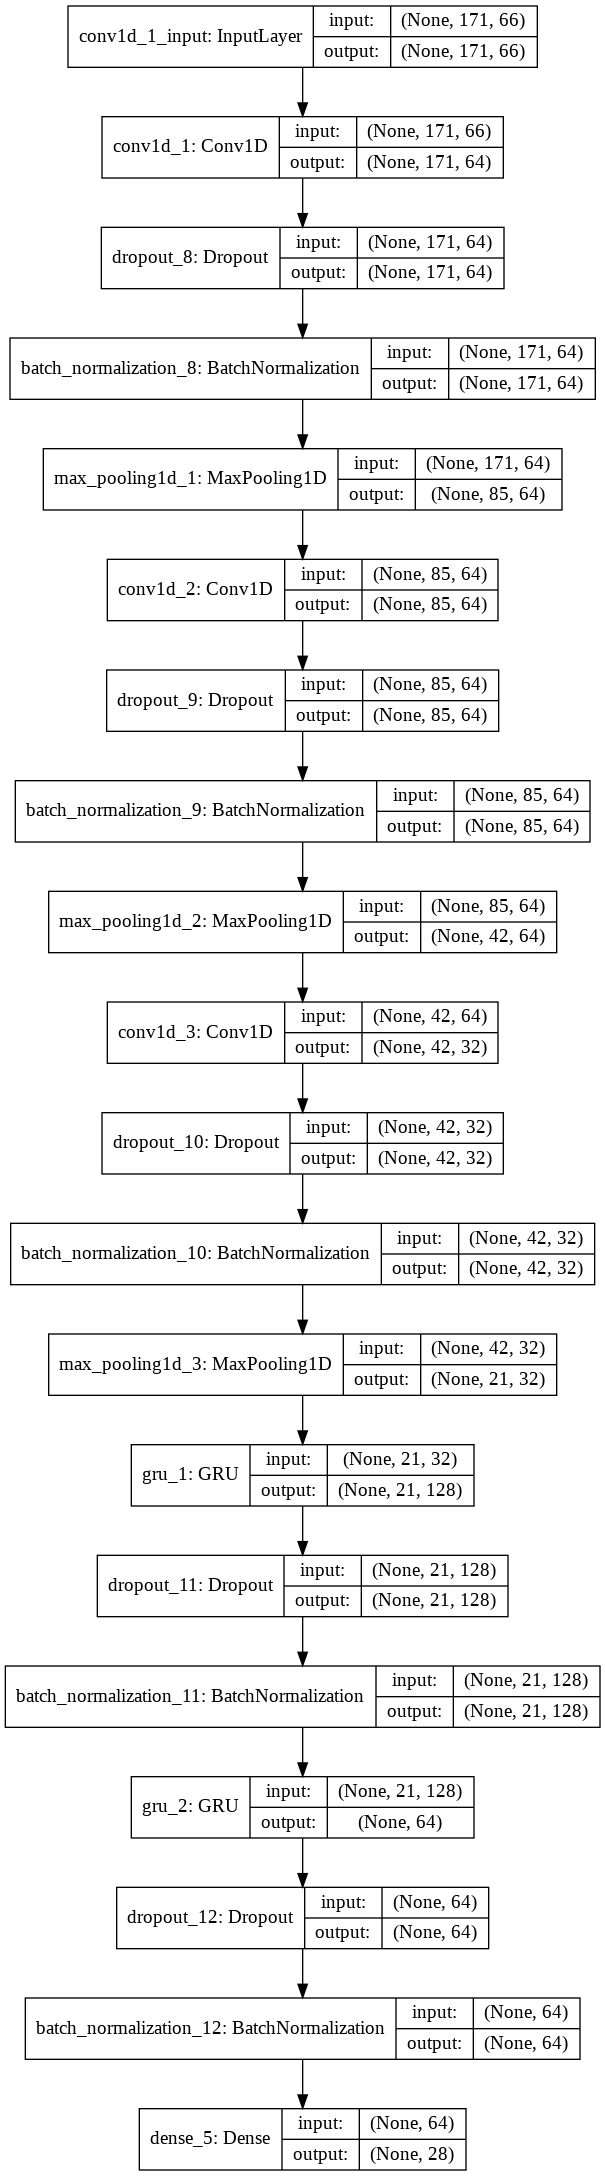

In [0]:
model_gru = Model_GRU()
plot_model(model_gru, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### Training Parameters :

In [0]:
num_models_CNN = 1  # On a choisi un model juste pour compiler le code
num_models_GRU = 1  # Si on choisi un nombre plus grand, l'entrainement prend beaucoup de temps
batch_size = 64
num_epochs_CNN = 1600
num_epochs_GRU = 300

models = []
y_aggregated = np.zeros((840,num_models_CNN + num_models_GRU), dtype = 'int')
es = TerminateOnBaseline(monitor='val_acc', baseline=0.80)

### Training the models :

#### CNN models :

In [0]:
for i in range(num_models_CNN):
  print("Model " + str(i+1) + " has completed the Training")
  model = Model_CNN(nb_filters1, nb_filters2, nb_filters3, nb_filters4, conv1_size, conv2_size, conv3_size, conv4_size, pool_size, nb_classes)
  model.fit(train_data_image, 
            train_labels_CNN, 
            validation_data = (validation_data_image, validation_labels_CNN), 
            batch_size=batch_size,epochs=num_epochs_CNN, verbose=1, callbacks=[es])
  
  models +=[model]
  print("Model " + str(i+1) + " has completed the Training")

  # serialize model to JSON
  model_json = model.to_json()
  with open("CNN_"+str(i+1)+".json", "w") as json_file:
      json_file.write(model_json)
  # serialize weights to HDF5
  model.save_weights("CNN_"+str(i+1)+".h5")
  print("Saved model to disk")

  # Prediction on the test set
  y_pred = model.predict(X_test_image)
  y_pred = np.argmax(y_pred, axis = 1)
  y_pred = y_pred + 1
  y_aggregated[:,i] = y_pred

Model 1 has completed the Training


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), input_shape=(171, 22, ..., padding="same")`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (4, 4), padding="same")`
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), data_format="channels_first")`
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="same")`
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `MaxPooling2D` call to the Keras

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 1764 samples, validate on 196 samples
Epoch 1/1600
1764/1764 [==============================] - 10s 6ms/step - loss: 4.5333 - categorical_accuracy: 0.0312 - val_loss: 3.4133 - val_categorical_accuracy: 0.0459
Epoch 2/1600
1764/1764 [==============================] - 1s 426us/step - loss: 4.5982 - categorical_accuracy: 0.0323 - val_loss: 3.3899 - val_categorical_accuracy: 0.0510
Epoch 3/1600
1764/1764 [==============================] - 1s 418us/step - loss: 4.4979 - categorical_accuracy: 0.0397 - val_loss: 3.3737 - val_categorical_accuracy: 0.0561
Epoch 4/1600
1764/1764 [==============================] - 1s 423us/step - loss: 4.4792 - categorical_accuracy: 0.0363 - val_loss: 3.3659 - val_categorical_accuracy: 0.0612
Epoch 5/1600
1764/1764 [==============================] - 1s 446us/step - loss: 4.4417 - categorical_accuracy: 0.0448 - val_loss: 3.3478 - val_categorical_accuracy: 0.066

#### GRU models :

In [0]:
for i in range(num_models_GRU):
  print("Model " + str(i+1) + " has started the Training")
  model = Model_GRU()
  model.fit(train_data_world.reshape((train_data_world.shape[0],171,66)), 
            train_labels_GRU, 
            validation_data = (validation_data_world.reshape((validation_data_world.shape[0],171,66)), validation_labels_GRU), 
            batch_size=batch_size,epochs=num_epochs_GRU, verbose=1, callbacks=[es])
  
  models +=[model]
  print("Model " + str(i+1) + " has completed the Training")

  # serialize model to JSON
  model_json = model.to_json()
  with open("GRU_"+str(i+1)+".json", "w") as json_file:
      json_file.write(model_json)
  # serialize weights to HDF5
  model.save_weights("GRU_"+str(i+1)+".h5")
  print("Saved model to disk")

  # Prediction on the test set
  y_pred = model.predict(X_test_world.reshape((840,171,66)))
  y_pred = np.argmax(y_pred, axis = 1)
  y_pred = y_pred + 1
  y_aggregated[:,i + num_models_CNN] = y_pred

Model 1 has started the Training
Train on 1764 samples, validate on 196 samples
Epoch 1/300
1764/1764 [==============================] - 6s 4ms/step - loss: 3.8949 - acc: 0.0340 - val_loss: 4.0836 - val_acc: 0.0306
Epoch 2/300
1764/1764 [==============================] - 3s 2ms/step - loss: 3.7879 - acc: 0.0374 - val_loss: 3.7906 - val_acc: 0.0255
Epoch 3/300
1764/1764 [==============================] - 3s 1ms/step - loss: 3.6603 - acc: 0.0459 - val_loss: 3.5048 - val_acc: 0.0204
Epoch 4/300
1764/1764 [==============================] - 3s 2ms/step - loss: 3.5365 - acc: 0.0482 - val_loss: 3.5474 - val_acc: 0.0255
Epoch 5/300
1764/1764 [==============================] - 3s 1ms/step - loss: 3.3853 - acc: 0.0658 - val_loss: 3.3672 - val_acc: 0.0510
Epoch 6/300
1764/1764 [==============================] - 3s 2ms/step - loss: 3.3559 - acc: 0.0573 - val_loss: 3.3370 - val_acc: 0.0816
Epoch 7/300
1764/1764 [==============================] - 3s 1ms/step - loss: 3.2763 - acc: 0.0669 - val_loss: 

### Aggregating the Models :

In [0]:
y_predicted = np.zeros(840, dtype = 'int')
for i in range(840):
  array = list(y_aggregated[i,:])
  classe = vote_majoritaire(array)
  y_predicted[i] = classe

In [0]:
validation_labels_GRU.shape

(196, 28)

In [0]:
print("The accuracy of the aggregated model is : " + str(len(y_predicted[y_predicted == labels])/8.4)+" %.")

The accuracy of the aggregated model is : 0.0 %.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


### Exporting the Result :

Ici, on exporte le resultat sur le test en fichier csv pour le soumettre sur Kaggle.

In [0]:
import pandas as pd
df = pd.DataFrame(y_predicted, columns =['prediction'])
df.to_csv('prediction12.csv')
!cp prediction12.csv "drive/My Drive/"

## Loading our best Models :

Dans cette partie, les models finaux avec lesquels nous avons travailler vont être charger du drive pour ensuite faire les prédictions.

Donc, pour ce faire, il faut charger les models envoyés avec le code dans le drive. Le dossier des modèles contient 15 modèles (six modèles CNN et neuf modèles GRU).

Les modèles serons aggregés avec système de vote majoritaire avec la fonction ``vote_majoritaire``.

In [0]:
list_models_CNN = ["cnn_prof1","cnn_prof2","cnn_prof3","cnn_prof4","cnn_prof5","cnn_prof6"]
list_models_GRU = ["GRU","GRU_81_1","GRU_82_1","GRU_82_2","GRU_82_3","GRU_82_4","GRU_84_1","GRU_85_1","GRU_85_2"]

nb_models_CNN = len(list_models_CNN)
nb_models_GRU = len(list_models_GRU)
y_vote= np.zeros((840,nb_models_GRU + nb_models_CNN), dtype = 'int')

for i in range(nb_models_CNN):
  json_file = open(list_models_CNN[i]+".json", 'r')
  loaded_model_json = json_file.read()
  json_file.close()
  model = model_from_json(loaded_model_json)
  # load weights into new model
  model.load_weights(list_models_CNN[i]+".h5")
  print("CNN Model "+str(i+1)+ " is loaded from disk")
  model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

  y = model.predict(X_test_image)
  y = np.argmax(y, axis = 1)
  y = y + 1
  y_vote[:,i] = y

for i in range(nb_models_GRU):
  json_file = open(list_models_GRU[i]+".json", 'r')
  loaded_model_json = json_file.read()
  json_file.close()
  model = model_from_json(loaded_model_json)
  # load weights into new model
  model.load_weights(list_models_GRU[i]+".h5")
  print("GRU Model "+str(i+1)+ " is loaded from disk")
  model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

  y = model.predict(X_test_world.reshape((840,171,66)))
  y = np.argmax(y, axis = 1)
  y = y + 1
  y_vote[:,i+nb_models_CNN] = y

CNN Model 1 is loaded from disk
CNN Model 2 is loaded from disk
CNN Model 3 is loaded from disk
CNN Model 4 is loaded from disk
CNN Model 5 is loaded from disk
CNN Model 6 is loaded from disk
GRU Model 1 is loaded from disk
GRU Model 2 is loaded from disk
GRU Model 3 is loaded from disk
GRU Model 4 is loaded from disk
GRU Model 5 is loaded from disk
GRU Model 6 is loaded from disk
GRU Model 7 is loaded from disk
GRU Model 8 is loaded from disk
GRU Model 9 is loaded from disk
GRU Model 10 is loaded from disk


In [0]:
y_pred = np.zeros(840, dtype = 'int')
for i in range(840):
  y_pred[i] = vote_majoritaire(list(y_vote[i,:]))

In [0]:
df = pd.DataFrame(y_pred, columns=['prediction'])
df.to_csv('predictions.csv')
!cp predictions.csv "drive/My Drive/"

#### The best GRU Model :

In [0]:
json_file = open("GRU_85_1.json", 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("GRU_85_1.h5")
print("Best GRU Model is loaded from disk")
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

y = model.predict(X_test_world.reshape((840,171,66)))
y = np.argmax(y, axis = 1)
y = y + 1

df = pd.DataFrame(y columns =['prediction'])
df.to_csv('predictions_GRU.csv')
!cp predictions_GRU.csv "drive/My Drive/"

Best GRU Model is loaded from disk
